<a href="https://colab.research.google.com/github/ccsosa/R_Examples/blob/master/HMM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 12. Hidden Markov Models
### by Chrystian Sosa, Miguel Romero and Nicolás López
#### Tuesday 02/06/2020

Book Repository: https://github.com/miguelfrocha/BioinformaticsAlgorithmsBook

**Proceso de Márkov**: Proceso o fenómeno aleatorio dependiente del tiempo pero que carece de memoria, es decir, que la distribución de probabilidad del valor futuro de una variable aleatoria depende únicamente de su valor presente (_propiedad de Márkov_)

**Modelo Oculto de Markov (HMM)**: Modelo estadístico donde el sistema a estudiar es un _proceso de Márkov_ con parámetros desconocidos. El objetivo es por tanto determinar los parámetros del modelo a partir de los parámetros observables

Como ejemplo, se mostrará la manera de modelar un mRNA maduro a partir de un HMM. El mRNA se compone, en ese orden, de 3 partes: la zona 5-UTR, luego la región que será traducida (CDS) y luego la zona 3-UTR.

Estas tres partes conforman una estructura gramatical que define un mRNA maduro, como si fueran las palabras de una oración.

Un Modelo Oculto de Márkov se compone de:

* Conjunto de estados ($S$): Corresponden a los estados que se quieren analizar. En el ejemplo anterior, corresponden a las 3 zonas de un mRNA(5-UTR, CDS, 3-UTR), más un estado de inicio y un estado de finalización.

* Conjunto de valores observables ($A$): corresponden a la salida que es explicada por el modelo. Para el ejemplo, corresponde a cada uno de los caracteres (ACGT).

* Probabilidades iniciales ($I(S_i)$): Probabilidad de que el primer estado sea el estado `i`, es decir, cada uno de los estados existentes.

* Probabilidades de Emisión ($e_{i,a}$): Probabilidad de que cada uno de los estados  `i` (ocultos) emita el valor observable `a`.

* Probabilidades de Transición ($T_{i,j}$): Probabilidad de cambiar de un estado `i` a un estado `j`, incluído él mismo.

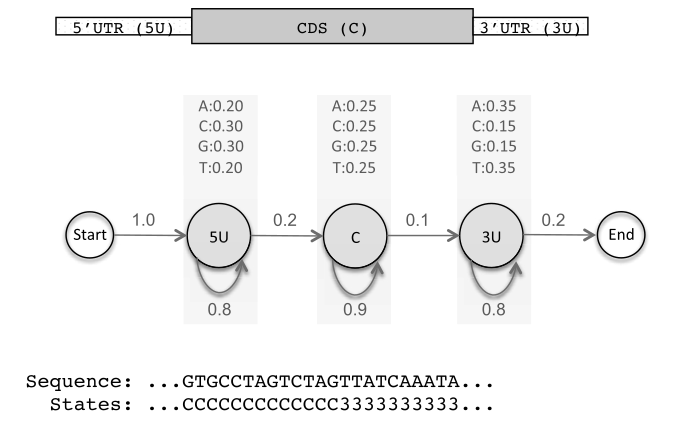

Lista de Algoritmos usado en el HMM:

- Joint probability:

Dada una secuencia observada ($O$) y una cadena de estados ($S$), retorna la multiplicación sucesiva de probabilidades de transición y emisión.

- Forward probability:

Retorna la matriz de probabilidades de cada estado en cada posición de la secuencia.

- Backward probability:

Calcula la probabilidad de que a partir de una posición `i` se genere el resto de la secuencia desde `i` hasta el final.

- Viterbi Optimization (Prediction)

Dada solamente una secuencia, esta función calcula la cadena de estados más probable para dicha secuencia.

- Bauch-Welch Algorithm (Learning)

Esta función aprende y actualiza la s probabilidades de emisión y de transición, a partir de secuencias observadas no etiquetadas.

# Código en Python

In [0]:
#@title
class HiddenMarkovModel:
    
    def __init__(self, init_probs, emission_probs, trans_probs):
        """Create a constructor based on three different attributes: probability of start states; emission probabilities matrix; transition probabilities matrix.
        Both emission and transition probability matrices can be implemented as dictionaries of dictionaries. States and symbols are represented as lists and can be infered from the probabilities.
        """
        self.initstate_probs = init_probs
        self.emission_probs = emission_probs
        self.transition_probs = trans_probs
        self.states = self.emission_probs.keys()
        self.symbols = list(self.emission_probs[list(self.emission_probs.keys())[0]].keys())

    
    def get_init_prob(self, state):
        '''Get initial probability of a given state'''
        if state in self.states:
            return (self.initstate_probs[state])
        else:
            return 0

    def get_emission_prob(self, state, symbol):
        '''Get probability of a given state to emit a symbol'''
        if state in self.states and symbol in self.symbols:
            return (self.emission_probs[state][symbol])
        else:
            return 0
        
    def get_transition_prob(self, state_orig, state_dest):
        '''Get probability of transition from a origin state to destination state'''
        if state_orig in self.states and state_dest in self.states:
            return (self.transition_probs[state_orig][state_dest])
        else:
            return 0
    
    
    def set_init_prob(self, state, p):
        '''Set initial probability of a given state'''
        if state in self.states:
            self.initstate_probs[state] = p

    def set_emission_prob(self, state, symbol, p):
        '''Set probability of a given state emit a symbol'''
        if state in self.states and symbol in self.symbols:
            self.emission_probs[state][symbol] = p

    def set_transition_prob(self, state_orig, state_dest, p):
        '''Set probability of transition from a origin state to destination state'''
        if state_orig in self.states and state_dest in self.states:
            self.transition_probs[state_orig][state_dest] = p
        
    def joint_probability(self, sequence, path):
        '''Given an observed sequence and a corresponding state path calculate the probability of the sequence given the path under the model'''
        seq_len = len(sequence)
        if seq_len == 0:
            return None
        
        path_len = len(path)
        if seq_len != path_len:
            print ("Observed sequence and state path of different lenghts!")
            return None
        
        prob = self.get_init_prob(path[0]) * self.get_emission_prob(path[0], sequence[0])
        for i in range(1, len(sequence)):
            prob = prob * self.get_transition_prob(path[i-1], path[i]) * self.get_emission_prob(path[i], sequence[i])
        
        return prob
    
    
    '''
      If no state path is provided, the goal is to calculate the total probability of the sequence, P(O|M). 
      This probability can be yield by summing the probabilities of all possible paths, which is an 
      exponentially large number of paths, but can be efficiently calculated with the Forward algorithm.
    '''
    def forward(self, sequence):
        '''Given an observed sequence calculate the list of forward probabilities of the sequence
        using the chain rules'''
        seq_len = len(sequence)
        if seq_len == 0:
            return []

        # calculate the product of the initial probability of each state and the first symbol of the sequence
        prob_list = [{}]
        for state in self.states:
            prob_list[0][state] = self.get_init_prob(state) * self.get_emission_prob(state, sequence[0])
        # iterate through the sequence and for each state multiply by the transition probability with any other of the possibles states; this corresponds to a jump to a new state
        # once in this new state multiply by the corresponding emission probability of the sequence symbol in that state
        for i in range(1, seq_len):
            prob_list.append({})
            for state_dest in self.states:
                prob = 0
                for state_orig in self.states:
                    prob += prob_list[i-1][state_orig] * self.get_transition_prob(state_orig, state_dest)
                prob_list[i][state_dest] = prob * self.get_emission_prob(state_dest, sequence[i])
                
        return prob_list
        # in alternative one can return the sum of all probabilities for the last symbol of the sequence
        #return sum(probs_list[-1].values())
    
    
    '''
      This provides the probability of starting at state S i and position t and generating the remainder 
      of the observed sequence ot...oT .
    '''
    def backward(self, sequence):
        '''Given an observed sequence calculate the list of backward probabilities of the sequence
        This is the probability of starting in a state si at position t of the sequence
        and generate the remainder of the sequence from t to end. For this we start from the end of the sequence and compute as a variant of the forward algorithm.
        The recurrence formula for a position i and state k is given by the sum of the product of transition probability of any state to stake k times the emission probability the observed sequence symbol at position i being emitted by any of the states times backward probability of the state at position i+1. Probability of the states at the last sequence symbol is 1.
        '''
        seq_len = len(sequence)
        if seq_len == 0:
            return []

        beta = [{}]
        for state in self.states:
            beta[0][state] = 1

        for i in range(seq_len - 1, 0, -1):
            beta.insert(0, {})
            for state_orig in self.states:
                prob = 0
                for state_dest in self.states:
                    prob += beta[1][state_dest] * self.get_transition_prob(state_orig, state_dest) * self.get_emission_prob(state_dest, sequence[i])  
                beta[0][state_orig] = prob
        return beta
    
    
    '''
      Given an HMM M and an observed sequence O, the task of the decoder is to find the most probable
      state path π.
    '''
    def viterbi(self, sequence):
        '''Viterbi algorithm is a dynamic programming algorithm that allows to calculate the most probable state path for an observed sequence.
            The recurrence is given by: probability of symbol x at position t and state i
            p_i (x, t) = emission_w(x) * max {p_w(x, t-1) * p(i | w)}
        '''
        seq_len = len(sequence)    
        if seq_len == 0:
            return []
        
        viterbi = {}
        state_path = {}
        # initialize the probabilities for the first symbol
        for state in self.states:
            viterbi[state] = self.get_init_prob(state) * self.get_emission_prob(state, sequence[0])
            state_path[state] = [state]

        # compute recursively until the last element
        for t in range(1, seq_len):
            new_state_path = {}
            new_path = {}
            viterbi_tmp = {}
            for state_dest in self.states:
                intermediate_probs = []
                for state_orig in self.states:
                    prob = viterbi[state_orig] * self.get_transition_prob(state_orig, state_dest)
                    intermediate_probs.append((prob, state_orig))
                
                (max_prob, max_state) = max(intermediate_probs)
                prob = self.get_emission_prob(state_dest, sequence[t]) * max_prob      
                viterbi_tmp[state_dest] = prob
                new_state_path[state_dest] = max_state
                new_path[state_dest] = state_path[max_state] + [state_dest]
                
            viterbi = viterbi_tmp
            state_path = new_path # just keep the optimal path
    
        max_state = None
        max_prob = 0
        # among the last states find the best probability and the best path
        for state in self.states:
            if viterbi[state] > max_prob:
                max_prob = viterbi[state]
                max_state = state
                
        return (max_prob, state_path[max_state])
        
    
    def baum_welch(self, sequence):
        '''Computes an update of the emission and transition probabilities based on observed sequence
        Expectation phase: expected emission and transition probabilities are calculated based on the gamma and xi formulas
        Maximization phase: updates to the emission and transition probabilities are made based on e_hat and T_hat formulas
        '''
        seq_len = len(sequence)    
        if seq_len == 0:
            return []
        
        alpha = self.forward(sequence)
        beta = self.backward(sequence)        
        
        # Expectation phase
        # gamma: probs. for finding a symbol w at position t in state i;  product of the forward (alpha) and backward (beta) probs for all t and all i
        gamma = [{} for t in range(seq_len)] 
        # xi: probs for transition between state i at position t and state j at position t+1, for all i,j and t
        xi = [{} for t in range(seq_len - 1)]  
        for t in range(seq_len):
            # compute gamma
            sum_alpha_beta = 0
            for i in self.states:
                gamma[t][i] = alpha[t][i] * beta[t][i]
                sum_alpha_beta += gamma[t][i]
                
            for i in self.states:
                gamma[t][i] = gamma[t][i] / sum_alpha_beta
            
            # set initial probs
            if t == 0:
                self.set_init_prob(i, gamma[t][i])
            
            # compute xi values up to T - 1
            if t == seq_len - 1:
                continue
            
            sum_probs = 0
            for state_orig in self.states:
                xi[t][state_orig] = {}
                for state_dest in self.states:
                    p = alpha[t][state_orig] * self.get_transition_prob(state_orig, state_dest) * self.get_emission_prob(state_dest, sequence[t + 1]) * beta[t + 1][state_dest]
                    xi[t][state_orig][state_dest] = p 
                    sum_probs += p
                    
            for state_orig in self.states:
                for state_dest in self.states:
                    xi[t][state_orig][state_dest] /= sum_probs 
                    
        # Maximization step: with gamma and xi calculated re-estimate emissions and transitions
        # re-estimate emissions
        for i in self.states:
            denominator = 0
            for t in range(seq_len):
                denominator += gamma[t][i]

            for w in self.symbols:
                numerator = 0.0
                for t in range(seq_len):
                    if sequence[t] == w:
                        numerator += gamma[t][i]
                if denominator > 0:
                    self.set_emission_prob(i, w, numerator / denominator)
                else:
                    self.set_emission_prob(i, w, 0.0)
                
        # re-estimate transitions    
        # now that we have gamma and xi let us re-estimate
        for i in self.states:
            for j in self.states:
                denominator = 0.0
                for t in range(seq_len -1):
                    denominator += gamma[t][i]
                numerator = 0.0
                for t in range(seq_len -1):
                    numerator += xi[t][i][j]
                self.set_transition_prob(i, j, numerator / denominator)
                if denominator > 0:
                    self.set_transition_prob(i, j, numerator / denominator)
                else:
                    self.set_transition_prob(i, j, 0.0)

## Ejemplo
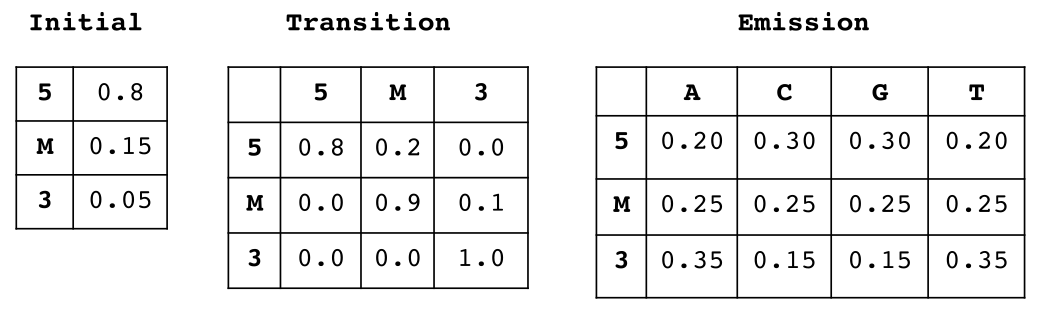

In [0]:
initial_probs = {"5": 0.8,"M": 0.15,"3": 0.05}    
emission_probs = {"5" : {"A": 0.20, "C": 0.30, "G":0.30, "T":0.20}, "M" : {"A":0.25, "C":0.25, "G":0.25, "T":0.25}, "3": {"A":0.35, "C":0.15, "G":0.15, "T":0.35}}
transition_probs = {"5":{"5": 0.8,"M": 0.2,"3": 0.0},"M":{"5": 0.0,"M": 0.9,"3": 0.1}, "3":{"5": 0.0,"M": 0.0,"3": 1.0}}

hmm = HiddenMarkovModel(initial_probs, emission_probs, transition_probs)

### Joint probability

In [0]:
# joint probability of observed sequence and state path
sequence = "ATGCAATGCGCATGCTAAAA"
statepath = "555555MMMMMM33333333"
prob = hmm.joint_probability(sequence, statepath)
print ("\nJoint probability of " + sequence + " and  " + statepath + " : " + str(prob))


Joint probability of ATGCAATGCGCATGCTAAAA and  555555MMMMMM33333333 : 4.501692159048002e-15


### Forward

In [0]:
# forward probabilities
seq = "ATGTGTGCACGCACCGTGCGACGCGTCGCGGAAGCTGTTATA"
alpha = hmm.forward(seq)
alpha_prob = sum(alpha[-1].values())
print ("\nForward probability of " + seq + " : " + str(alpha_prob))


Forward probability of ATGTGTGCACGCACCGTGCGACGCGTCGCGGAAGCTGTTATA : 1.2285267219485752e-26


### Viterbi

In [0]:
# Optimal path with Viterbi
seq = "ACAATGCCGTCTCCGCGACGCCTTTAATTAT"
(probs, path) = hmm.viterbi(seq)
print ("\nRunning Viterbi algorithm for seq " + seq)
print ("Optimal probability: " + str(probs))
print ("Optimal statepath: " + "".join(path))


Running Viterbi algorithm for seq ACAATGCCGTCTCCGCGACGCCTTTAATTAT
Optimal probability: 7.43672071579352e-21
Optimal statepath: 55MMMMMMMMMMMMMMMMMMMM333333333


### Baum-Welch

In [0]:
# learn with Forward-Backward
print ("\n\nProbabilities before learning")
print ("Emission probabilities")
print (hmm.emission_probs)
print ("Transition probabilities")
print (hmm.transition_probs)

print ("\nOptimizing probabilities with Baum-Welch: " )
seq = "AGGGACGCTAAGCTCGCGCGAGCGACGCCATTATAGCGTAGCTTTTTAT"
print ("Input sequence: " + seq)
hmm.baum_welch(seq)
seq = "ATGTGGCGCGCGGAAGCTGTTATA"
print ("Input sequence: " + seq)
hmm.baum_welch(seq)
seq = "AATCGCGAGCGGCCCGCGAAGCTGTTTTTTAATA"
print ("Input sequence: " + seq)
hmm.baum_welch(seq)
seq = "ATGATGCGCTCGATGCTATCGCGCCGCGCGCGAGCGGCCCGCGAAGCTGTTTTAGTTAATAATGATATTGTA"
print ("Input sequence: " + seq)
hmm.baum_welch(seq)

print ("\nProbabilities after learning")
print ("Emission probabilities")
print (hmm.emission_probs)
print ("Transition probabilities")
print (hmm.transition_probs)



Probabilities before learning
Emission probabilities
{'5': {'A': 0.2, 'C': 0.3, 'G': 0.3, 'T': 0.2}, 'M': {'A': 0.25, 'C': 0.25, 'G': 0.25, 'T': 0.25}, '3': {'A': 0.35, 'C': 0.15, 'G': 0.15, 'T': 0.35}}
Transition probabilities
{'5': {'5': 0.8, 'M': 0.2, '3': 0.0}, 'M': {'5': 0.0, 'M': 0.9, '3': 0.1}, '3': {'5': 0.0, 'M': 0.0, '3': 1.0}}

Optimizing probabilities with Baum-Welch: 
Input sequence: AGGGACGCTAAGCTCGCGCGAGCGACGCCATTATAGCGTAGCTTTTTAT
Input sequence: ATGTGGCGCGCGGAAGCTGTTATA
Input sequence: AATCGCGAGCGGCCCGCGAAGCTGTTTTTTAATA
Input sequence: ATGATGCGCTCGATGCTATCGCGCCGCGCGCGAGCGGCCCGCGAAGCTGTTTTAGTTAATAATGATATTGTA

Probabilities after learning
Emission probabilities
{'5': {'A': 0.2182988801557371, 'C': 0.21244038913050345, 'G': 0.2729290498400088, 'T': 0.2963316808737504}, 'M': {'A': 0.11520006243844243, 'C': 0.42048003112834664, 'G': 0.4018021387738466, 'T': 0.06251776765936479}, '3': {'A': 0.3261351196104929, 'C': 0.005149770690367049, 'G': 0.15631290792675168, 'T': 0.5124

# **Usos en biología de modelos ocultos de Markov**


### **Un poco de historia**

![Baldi et al., 1994](https://raw.githubusercontent.com/ccsosa/R_Examples/master/hmm2.png) (https://www.pnas.org/content/pnas/91/3/1059.full.pdf)
_____________________________________________________________________________


### **Aplicaciones**

- Estructura proteicas (entropía)
- Clasificación de familias proteicas (Globulinas, inmunoglobulinas, kinasas)

![Yoon et al., 2009](https://raw.githubusercontent.com/ccsosa/R_Examples/master/hmm3.png)
(https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2766791/pdf/CG-10-402.pdf)




_____________________________________________________________________________
**Profile HMM**

![](https://raw.githubusercontent.com/ccsosa/R_Examples/master/hmm1.png)
(http://web.cs.iastate.edu/~honavar/Krogh98a.pdf)
(https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2766791/pdf/CG-10-402.pdf)

-Scoring (forward)(reducción del tiempo computacional)
-*Optimal alignment* (Viterbi)
- ¿Cuáles parametros? (Baum-Welch)

![Profile](https://raw.githubusercontent.com/ccsosa/R_Examples/master/hmm5a.png)

_____________________________________________________________________________

**Perfiles de familias proteicas (PI-PLC-X)**

![Family: PI-PLC-X ](https://raw.githubusercontent.com/ccsosa/R_Examples/master/logo_image.png)



Ejemplos:

![Jpred4](https://raw.githubusercontent.com/ccsosa/R_Examples/master/hmm4.png)

- Estructuras secundarias (tres estados de emisión)
- http://www.compbio.dundee.ac.uk/jpred/
-http://www.compbio.dundee.ac.uk/jpred4/results/jp_nufNjfZ/jp_nufNjfZ.results.html

http://www.compbio.dundee.ac.uk/jpred4/results/jp_nufNjfZ/jp_nufNjfZ.svg.html

_____________________________________________________________________________


**Algunos recursos**
- https://www.ebi.ac.uk/Tools/hmmer/
- https://www.ebi.ac.uk/Tools/hmmer/results/E472D854-A382-11EA-AB17-B2E5DBC3747A/score

-https://prosite.expasy.org/scanprosite/
-https://prosite.expasy.org/cgi-bin/prosite/ScanView.cgi?scanfile=560040494629.scan.gz




### **Usos en secuencias no relacionadas**

- **Pair HMM**
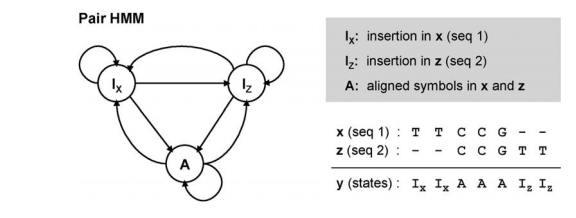 -ARN




* Alineamiento pareado
* ARN
* Secuencias no similares

_____________________________________________________________________________

http://www.homepages.ed.ac.uk/pkeightl//mcalign/mcinstructions.html


### **¡GRACIAS!**